# Solve Navier-Stokes equation based on 3D Spectral Neural Operator

[![DownloadNotebook](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/r2.5.0/resource/_static/logo_notebook_en.svg)](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/notebook/r2.5.0/mindflow/en/data_driven/mindspore_navier_stokes_SNO3D.ipynb)&emsp;[![DownloadCode](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/r2.5.0/resource/_static/logo_download_code_en.svg)](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/notebook/r2.5.0/mindflow/en/data_driven/mindspore_navier_stokes_SNO3D.py)&emsp;[![View Source On Gitee](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/r2.5.0/resource/_static/logo_source_en.svg)](https://gitee.com/mindspore/docs/blob/r2.5.0/docs/mindflow/docs/source_en/data_driven/navier_stokes_SNO3D.ipynb)

## Overview

Computational fluid dynamics is one of the most important techniques in the field of fluid mechanics in the 21st century. The flow analysis, prediction and control can be realized by solving the governing equations of fluid mechanics by numerical method. Traditional finite element method (FEM) and finite difference method (FDM) are inefficient because of the complex simulation process (physical modeling, meshing, numerical discretization, iterative solution, etc.) and high computing costs. Therefore, it is necessary to improve the efficiency of fluid simulation with AI.

Machine learning methods provide a new paradigm for scientific computing by providing a fast solver similar to traditional methods. Classical neural networks learn mappings between finite dimensional spaces and can only learn solutions related to a specific discretization. Different from traditional neural networks, Fourier Neural Operator (FNO) is a new deep learning architecture that can learn mappings between infinite-dimensional function spaces. It directly learns mappings from arbitrary function parameters to solutions to solve a class of partial differential equations.  Therefore, it has a stronger generalization capability. More information can be found in the paper, [Fourier Neural Operator for Parametric Partial Differential Equations](https://arxiv.org/abs/2010.08895).

Spectral Neural Operator (SNO) is the FNO-like architecture using polynomial transformation to spectral space (Chebyshev, Legendre, etc.) instead of Fourier.
SNO is characterized by smaller systematic bias caused by aliasing errors compared to FNO. One of the most important benefits of the architecture is that SNO supports multiple choice of basis, so it is possible to find a set of polynomials which is the most convenient for representation, e.g., respect symmetries of the problem or fit well into the solution interval. Besides, the neural operators, based on orthogonal polynomials, may be competitive with other spectral operators in case when the input function is defined on unstructured grid.

More information can be found in the paper, "[Spectral Neural Operators](https://arxiv.org/abs/2205.10573)". arXiv preprint arXiv:2205.10573 (2022).

This tutorial describes how to solve the Navier-Stokes equation using 3D Spectral neural operator.

## Navier-Stokes equation

Navier-Stokes equation is a classical equation in computational fluid dynamics. It is a set of partial differential equations describing the conservation of fluid momentum, called N-S equation for short. Its vorticity form in two-dimensional incompressible flows is as follows:

$$ \partial_t w(x, t)+u(x, t) \cdot \nabla w(x, t)=\nu \Delta w(x, t)+f(x), \quad x \in(0,1)^2, t \in(0, T] $$

$$ \nabla \cdot u(x, t)=0, \quad x \in(0,1)^2, t \in[0, T] $$

$$ w(x, 0)=w_0(x), \quad x \in(0,1)^2 $$

where $u$ is the velocity field, $w=\nabla \times u$ is the vorticity, $w_0(x)$ is the initial vorticity, $\nu$ is the viscosity coefficient, $f(x)$ is the forcing function.


## Problem Description

We aim to learn the operator mapping the vorticity at the first 10 time steps to the full trajectory [10, T]:

$$ w|_{(0, 1)^2 \times [0, 10]} \mapsto w|_{(0, 1)^2 \times [10, T]} $$

## Technology Path

MindFlow solves the problem as follows:

1. Training Dataset Construction.
2. Model Construction.
3. Optimizer and Loss Function.
4. Model Training.


## Spectral Neural Operator

The following figure shows the architecture of the Spectral Neural Operator, which consists of encoder, multiple spectral convolution layers (linear transformation in space of coefficients in polynomial basis) and decoder.
To compute forward and inverse polynomial transformation matrices for spectral convolutions, the input should be interpolated at the respective Gauss quadrature nodes (Chebyshev grid, etc.).
The interpolated input is lifted to a higher dimension channel space by a convolutional Encoder layer. The result comes to the input of a sequence of spectral (SNO) layers, each of which applies a linear convolution to its truncated spectral representation. The output of SNO layers is projected back to the target dimension by a convolutional Decoder, and finally interpolated back to the original nodes.

The spectral (SNO) layer performs the following operations: applies the polynomial transformation $A$ to spectral space (Chebyshev, Legendre, etc.); a linear convolution $L$ on the lower polynomial modes and filters out the higher modes; then applies the inverse conversion $S={A}^{-1}$ (back to the physical space). Then a linear convolution $W$ of input is added, and nonlinear activation is applied.

![Spectral Neural Operator model structure](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/r2.5.0/docs/mindflow/docs/source_en/data_driven/images/SNO.png)


In [1]:
import os
import time
import numpy as np

from mindspore import nn, ops, jit, data_sink, context, Tensor
from mindspore.common import set_seed
from mindspore import dtype as mstype

The following `src` pacakage can be downloaded in [applications/data_driven/navier_stokes/sno3d/src](https://gitee.com/mindspore/mindscience/tree/r0.7/MindFlow/applications/data_driven/navier_stokes/sno3d/src).


In [2]:
from mindflow import get_warmup_cosine_annealing_lr, load_yaml_config
from mindflow.utils import print_log
from mindflow.cell import SNO3D, get_poly_transform

from src import calculate_l2_error, UnitGaussianNormalizer, create_training_dataset, load_interp_data, visual

set_seed(0)
np.random.seed(0)

In [3]:
# set context for training: using graph mode for high performance training with GPU acceleration
context.set_context(mode=context.GRAPH_MODE, device_target='GPU', device_id=0)
use_ascend = context.get_context(attr_key='device_target') == "Ascend"
config = load_yaml_config('./configs/sno3d.yaml')
data_params = config["data"]
model_params = config["model"]
optimizer_params = config["optimizer"]
summary_params = config["summary"]

grid_size = data_params["resolution"]
input_timestep = model_params["input_timestep"]
output_timestep = model_params["extrapolations"]


## Training Dataset Construction

Download the training and test dataset: [data_driven/navier_stokes/dataset](https://download.mindspore.cn/mindscience/mindflow/dataset/applications/data_driven/navier_stokes_3d/) .

In this case, training data sets and test data sets are generated according to Zongyi Li's data set in [Fourier Neural Operator for Parametric Partial Differential Equations](https://arxiv.org/pdf/2010.08895.pdf) . The settings are as follows:

The initial condition $w_0(x)$ is generated according to periodic boundary conditions:

$$ w_0 \sim \mu, \mu=\mathcal{N}\left(0,7^{3 / 2}(-\Delta+49 I)^{-2.5}\right) $$

The forcing function is defined as:

$$ f(x)=0.1\left(\sin \left(2 \pi\left(x_1+x_2\right)\right)+\right.\cos(2 \pi(x_1+x_2))) $$

We use a time-step of 1e-4 for the Crank–Nicolson scheme in the data-generated process where we record the solution every t = 1 time units. All data are generated on a 256 × 256 grid and are downsampled to 64 × 64\. In this case, the viscosity coefficient $\nu=1e-4$, the number of samples in the training set is 1000, and the number of samples in the test set is 200.


In [4]:
load_interp_data(data_params, 'train')
train_loader = create_training_dataset(data_params, shuffle=True)
test_data = load_interp_data(data_params, 'test')
test_a = Tensor(test_data['a'], mstype.float32)
test_u = Tensor(test_data['u'], mstype.float32)

test_u_unif = np.load(os.path.join(data_params['root_dir'], 'test/test_u.npy'))

train_a = Tensor(np.load(os.path.join(
        data_params["root_dir"], "train/train_a_interp.npy")), mstype.float32)
train_u = Tensor(np.load(os.path.join(
        data_params["root_dir"], "train/train_u_interp.npy")), mstype.float32)

train a, u:  (1000, 10, 64, 64) (1000, 40, 64, 64)
test a, u:  (200, 10, 64, 64) (200, 40, 64, 64)


## Model Construction

The network is composed of 1 encoding layer, multiple spectral layers and decoding block:

- The encoding convolution corresponds to the `SNO3D.encoder` in the case, and maps the input data $x$ to the high dimension;

- A sequence of SNO layers corresponds to the `SNO3D.sno_kernel` in the case. Input matrices of polynomial transformations(forward and inverse conversions for each of three variables) are used to realize the transition between space-time domain and frequency domain;

- The decoding layer corresponds to `SNO3D.decoder` and consists of two convolutions.The decoder is used to obtain the final prediction.

In [5]:
n_modes = model_params['modes']
poly_type = data_params['poly_type']
transform_data = get_poly_transform(grid_size, n_modes, poly_type)
transform = Tensor(transform_data["analysis"], mstype.float32)
inv_transform = Tensor(transform_data["synthesis"], mstype.float32)

transform_t_axis = get_poly_transform(output_timestep, n_modes, poly_type)
transform_t = Tensor(transform_t_axis["analysis"], mstype.float32)
inv_transform_t = Tensor(transform_t_axis["synthesis"], mstype.float32)

transforms = [[transform, inv_transform]] * 2 + [[transform_t, inv_transform_t]]

In [6]:
if use_ascend:
    compute_type = mstype.float16
else:
    compute_type = mstype.float32

# prepare model
model = SNO3D(in_channels=model_params['in_channels'],
              out_channels=model_params['out_channels'],
              hidden_channels=model_params['hidden_channels'],
              num_sno_layers=model_params['sno_layers'],
              transforms=transforms,
              kernel_size=model_params['kernel_size'],
              compute_dtype=compute_type)

model_params_list = []
for k, v in model_params.items():
    model_params_list.append(f"{k}-{v}")
model_name = "_".join(model_params_list)

total = 0
for param in model.get_parameters():
    print_log(param.shape)
    total += param.size
print_log(f"Total Parameters:{total}")

(64, 10, 1, 1, 1)
(64, 64, 7, 7, 7)
(64, 64, 1, 1, 1)
(64, 64, 7, 7, 7)
(64, 64, 1, 1, 1)
(64, 64, 7, 7, 7)
(64, 64, 1, 1, 1)
(64, 64, 7, 7, 7)
(64, 64, 1, 1, 1)
(64, 64, 7, 7, 7)
(64, 64, 1, 1, 1)
(64, 64, 1, 1, 1)
(1, 64, 1, 1, 1)
Total Parameters:7049920


## Optimizer and Loss Function


In [ ]:

lr = get_warmup_cosine_annealing_lr(lr_init=optimizer_params["learning_rate"],
                                    last_epoch=optimizer_params["epochs"],
                                    steps_per_epoch=train_loader.get_dataset_size(),
                                    warmup_epochs=optimizer_params["warmup_epochs"])


steps_per_epoch = train_loader.get_dataset_size()
optimizer = nn.AdamWeightDecay(model.trainable_params(),
                               learning_rate=Tensor(lr),
                               eps=float(optimizer_params['eps']),
                               weight_decay=optimizer_params['weight_decay'])
loss_fn = nn.RMSELoss() #LpLoss()
a_normalizer = UnitGaussianNormalizer(train_a)
u_normalizer = UnitGaussianNormalizer(train_u)

## Training Function

With MindSpore>= 2.0.0, you can train neural networks using functional programming paradigms, and single-step training functions are decorated with jit. The data_sink function is used to transfer the step-by-step training function and training dataset.


In [8]:
def forward_fn(data, label):
    bs = data.shape[0]
    data = a_normalizer.encode(data)
    data = data.reshape(bs, input_timestep, grid_size, grid_size, 1).repeat(output_timestep, axis=-1)
    logits = model(data).reshape(bs, output_timestep, grid_size, grid_size)

    logits = u_normalizer.decode(logits)
    loss = loss_fn(logits.reshape(bs, -1), label.reshape(bs, -1))
    if use_ascend:
        loss = loss_scaler.scale(loss)
    return loss

grad_fn = ops.value_and_grad(
    forward_fn, None, optimizer.parameters, has_aux=False)

from mindspore.amp import DynamicLossScaler, auto_mixed_precision, all_finite
if use_ascend:
    loss_scaler = DynamicLossScaler(1024, 2, 100)
    auto_mixed_precision(model, 'O2')
else:
    loss_scaler = None

@jit
def train_step(data, label):
    loss, grads = grad_fn(data, label)
    if use_ascend:
        loss = loss_scaler.unscale(loss)
        is_finite = all_finite(grads)
        if is_finite:
            grads = loss_scaler.unscale(grads)
            loss = ops.depend(loss, optimizer(grads))
        loss_scaler.adjust(is_finite)
    else:
        loss = ops.depend(loss, optimizer(grads))
    return loss

sink_process = data_sink(train_step, train_loader, sink_size=200)


## Model Training

With **MindSpore version >= 2.0.0**, we can use the functional programming for training neural networks.


In [11]:
summary_dir = os.path.join(summary_params["root_dir"], model_name)
ckpt_dir = os.path.join(summary_dir, summary_params["ckpt_dir"])
if not os.path.exists(ckpt_dir):
    os.makedirs(ckpt_dir)

In [9]:
def train():
    for epoch in range(1, 1 + optimizer_params["epochs"]):
        local_time_beg = time.time()
        model.set_train(True)
        cur_loss = sink_process()
        local_time_end = time.time()
        epoch_seconds = local_time_end - local_time_beg
        step_seconds = (epoch_seconds/200)
        print_log(
            f"epoch: {epoch} train loss: {cur_loss} epoch time: {epoch_seconds:.3f}s step time: {step_seconds:5.3f}ms")

        if epoch % summary_params['test_interval'] == 0:
            model.set_train(False)
            calculate_l2_error(model, test_a, test_u, data_params, a_normalizer, u_normalizer)

In [11]:
train()

epoch: 1 train loss: 0.90118235 epoch time: 44.718s step time: 0.224s
epoch: 2 train loss: 0.91254395 epoch time: 40.240s step time: 0.201s
epoch: 3 train loss: 0.9374327 epoch time: 40.302s step time: 0.202s
epoch: 4 train loss: 0.85217404 epoch time: 40.482s step time: 0.202s
epoch: 5 train loss: 0.6309165 epoch time: 40.590s step time: 0.203s
epoch: 6 train loss: 0.4290015 epoch time: 40.576s step time: 0.203s
epoch: 7 train loss: 0.34428337 epoch time: 40.536s step time: 0.203s
epoch: 8 train loss: 0.34126174 epoch time: 40.564s step time: 0.203s
epoch: 9 train loss: 0.27420813 epoch time: 40.571s step time: 0.203s
epoch: 10 train loss: 0.2711888 epoch time: 40.554s step time: 0.203s
================================Start Evaluation================================
Error on Gauss grid: 0.28268588, on regular grid: 0.2779018060781111
predict total time: 26.014892578125 s
=================================End Evaluation=================================
epoch: 11 train loss: 0.2603902 ep

In [ ]:
visual(model, test_a, data_params, a_normalizer, u_normalizer)

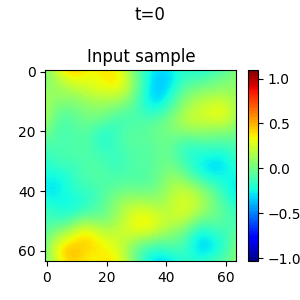

In [13]:
from IPython.display import Image, display
with open('images/input.gif', 'rb') as f:
    display(Image(data=f.read(), format='png', embed=True))

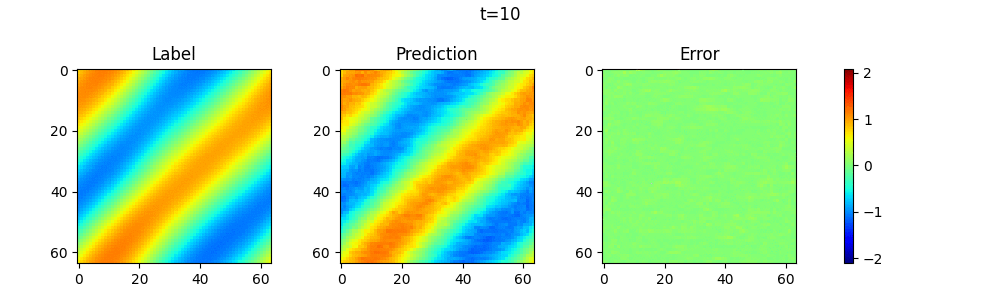

In [4]:
with open('images/result.gif', 'rb') as f:
    display(Image(data=f.read(), format='png', embed=True))